1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

The global minimum is achieved at the point [ 0.08984200644367521 , -0.7126564115232805 ]
where the function value is -1.0316284534898765
By starting with the initial guess equal to x0=[0,0] the minimum results 0.0


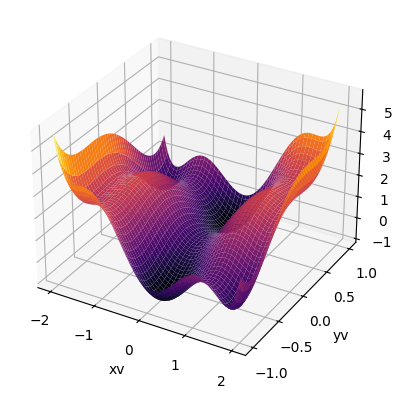

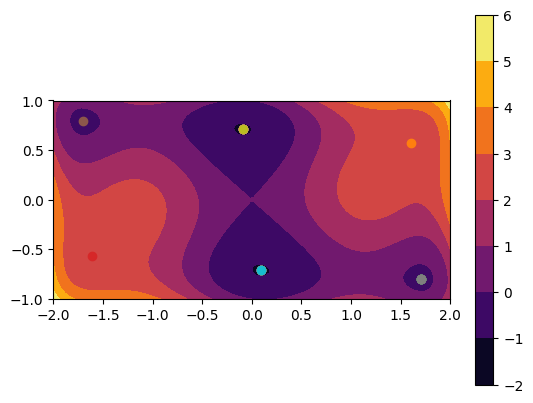

In [11]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import *
import pandas as pd

def f(X):
    x, y = X
    return (4 - 2.1*x**2 + (x**4)/3)*x**2 + x*y + (4*y**2 - 4)*y**2

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)
xv, yv = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(xv, yv, f([xv, yv]), cmap='inferno')
ax.set_xlabel('xv')
ax.set_ylabel('yv')
ax.set_zlabel('f(xv, yv)')

fig = plt.figure()
h = plt.contourf(x, y, f([xv, yv]), cmap='inferno')
plt.axis('scaled')
plt.colorbar()

rand_x0 = np.random.uniform(low=[-2, -1], high=[2, 1], size=(30, 2))

def print_fun(x, f, accepted):
    results.append((x[0], x[1], f))

results = []
for j in range(len(rand_x0)):
    r = basinhopping(f, rand_x0[j], minimizer_kwargs={"method":"BFGS"}, niter=0, callback=print_fun)
    plt.scatter(r.x[0], r.x[1])

df = pd.DataFrame(results, columns=['x', 'y', 'f(x, y)'])
min_index = df['f(x, y)'].idxmin()
print('The global minimum is achieved at the point [', df.loc[min_index, 'x'], ',', df.loc[min_index, 'y'], ']')
print('where the function value is', df['f(x, y)'].min())
#There is one global minimum, where the function is f(x, y) = -1.0316
#and it is yielded for the two points [0.0898, -0.7127] and [-0.0898, 0.7127]
#the others are just local minima

x0 = [0, 0]
r = minimize(f, x0)
print('By starting with the initial guess equal to x0=[0,0] the minimum results',r.fun)


2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

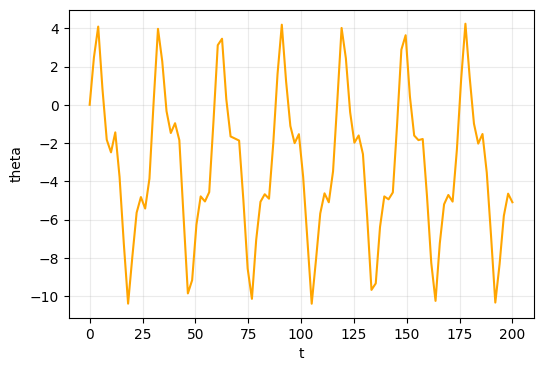

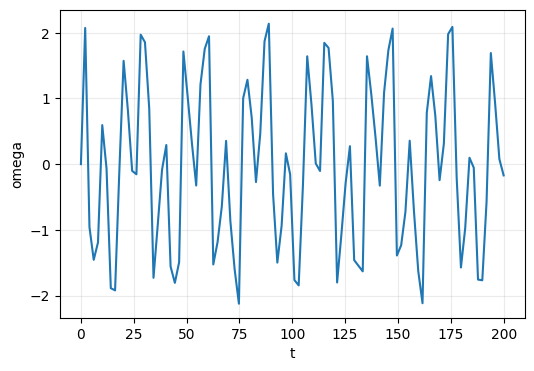

In [23]:
import numpy as np
from scipy import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#parameters
l = 10
Q = 2.0
d = 1.5
omega = 0.65
g = 9.81
T = 200

#initial condition
theta0 = 0
omega0 = 0
X0 = [omega0, theta0]

#solving the ODE
def derivative(X, time, Q, g, l, d, Omega):
    return(X[1], -(1/Q)*X[1] + (g/l)*np.sin(X[0]) + d*np.cos(omega*time))

t = np.linspace(0, T, 100)
X = odeint(derivative, X0, t, args=(Q, g, l, d, omega))

plt.figure(figsize=(6,4))
plt.plot(t, X[:, 0], 'orange')
plt.xlabel('t')
plt.ylabel('theta')
plt.grid(alpha=0.25)
plt.figure(figsize=(6,4))
plt.plot(t, X[:, 1])
plt.xlabel('t')
plt.ylabel('omega')
plt.grid(alpha=0.25)



3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

<Figure size 600x800 with 0 Axes>

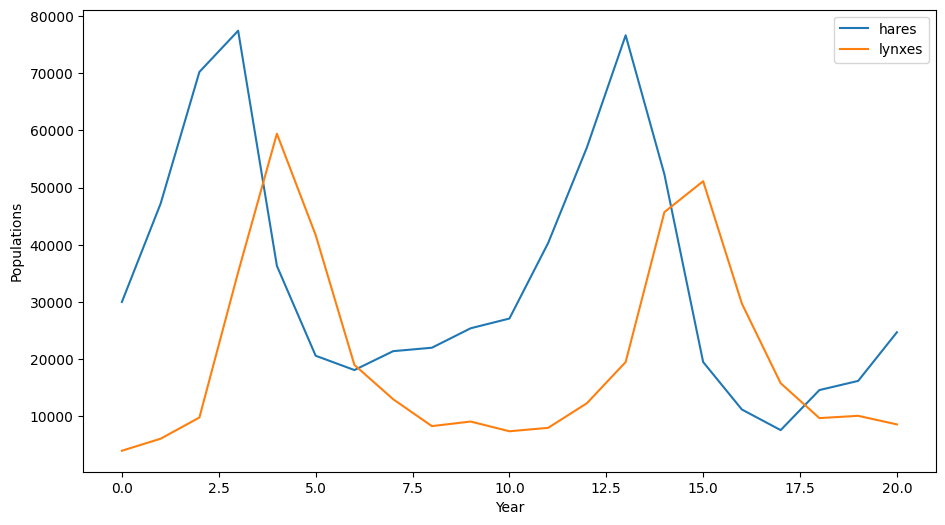

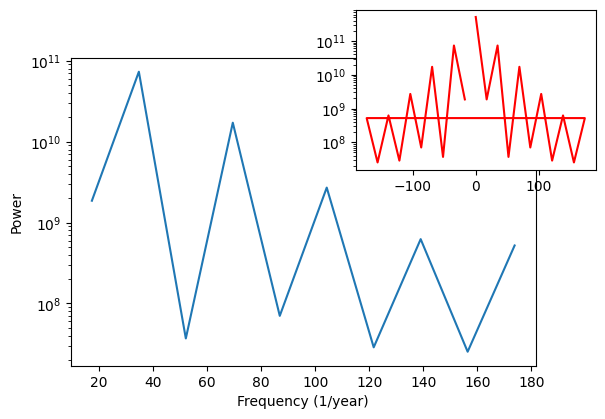

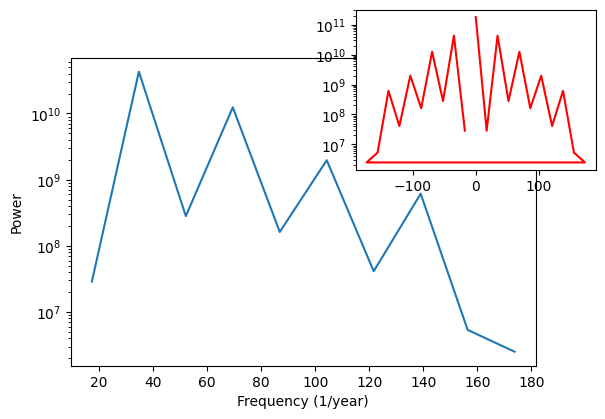

In [26]:
#!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import fftpack

data = np.loadtxt('data/populations.txt')
columns = ['year', 'hares', 'lynxes', 'carrots']
df = pd.DataFrame(data, columns=columns)

plt.figure(figsize=(6,8))
hares_array = np.array(df.loc[:, 'hares'])
lynxes_array = np.array(df.loc[:, 'lynxes'])
year = df['hares'].index.to_numpy()

plt.figure(figsize=(11,6))
plt.plot(year, hares_array)
plt.plot(year, lynxes_array)
plt.xlabel('Year')
plt.ylabel('Populations')
plt.legend(['hares', 'lynxes'])

hares_fft = fftpack.fft(hares_array)
lynxes_fft = fftpack.fft(lynxes_array)

hares_psd = np.abs(hares_fft)**2
lynxes_psd = np.abs(lynxes_fft)**2

fftfreq_hares = fftpack.fftfreq(len(hares_psd), 1./365)
fftfreq_lynxes = fftpack.fftfreq(len(lynxes_psd), 1./365)

i_hares = fftfreq_hares > 0
i_lynxes = fftfreq_lynxes > 0

plt.figure(figsize=(6,4))
plt.plot(fftfreq_hares[i_hares], hares_psd[i_hares])
plt.xlabel('Frequency (1/year)')
plt.ylabel('Power')
plt.yscale('log')

#inner plot to show the peak frequency
axes = plt.axes([0.6, 0.6, 0.4, 0.4])
plt.plot(fftfreq_hares[:40], hares_psd[:40], 'red')
#plt.step(axes, yticks=[])
plt.yscale('log')

plt.figure(figsize=(6,4))
plt.plot(fftfreq_lynxes[i_lynxes], lynxes_psd[i_lynxes])
plt.xlabel('Frequency (1/year)')
plt.ylabel('Power')
plt.yscale('log')

#inner plot to show the peak frequency
axes = plt.axes([0.6, 0.6, 0.4, 0.4])
plt.plot(fftfreq_lynxes[:40], lynxes_psd[:40], 'red')
#plt.step(axes, yticks=[])
plt.yscale('log')




4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

Text(0.5, 1.0, 'Reconstructed image')

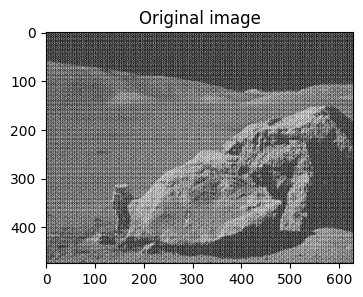

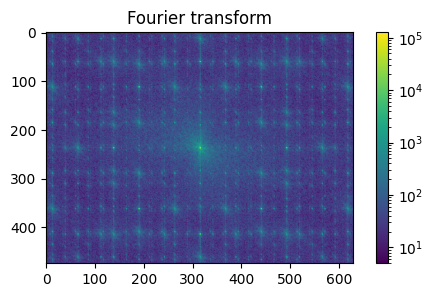

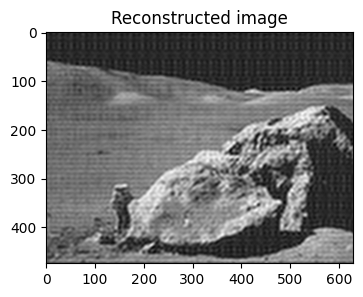

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import fftpack

plt.figure(figsize=(4,3))
image = plt.imread("images/moonlanding.png")
plt.imshow(image, cmap='gray')
plt.title('Original image')

image_fft = fftpack.fft2(image)
image_fft_shifted = fftpack.fftshift(image_fft)
image_power = np.abs(image_fft_shifted)

plt.figure(figsize=(6,3))
plt.imshow(image_power, norm=LogNorm(vmin=5))
plt.colorbar()
plt.title('Fourier transform')

image_fftcopy = image_fft.copy()

N = image_fft_shifted.shape[0]
M = image_fft_shifted.shape[1]
x, y = np.meshgrid(np.arange(M), np.arange(N))

a1 = 0.1
image_fftcopy[int(N*a1):int(N*(1-a1))] = 0
image_fftcopy[:, int(M*a1):int(M*(1-a1))] = 0

image_ifft = fftpack.ifft2(image_fftcopy)

plt.figure(figsize=(6,3))
plt.imshow(image_ifft.real, cmap='gray')
plt.title('Reconstructed image')